# Bayes Goes to War: U-boat Detection (Interactive Notebook)

This notebook accompanies the learning activity **"Bayes va a la guerra"**.
You will work with a simple Bayesian model to update your beliefs about the
presence of a U-boat in a given sea sector, based on observed sinkings.

**Please read the instructions in each section and answer the questions in your own words.**

## Learning goals

By the end of this notebook you should be able to:

- Identify the elements of a simple Bayesian model: **prior**, **likelihood**, and **posterior**.
- Implement a **discrete Bayes–Binomial model** in Python.
- Visualize how the posterior distribution changes when you:
  - observe more or fewer sinkings, and
  - choose different priors (optimistic vs. pessimistic).
- Explain how this type of probabilistic reasoning could be relevant in modern Data Science applications.

## Historical context (very brief)

During World War II, Allied convoys crossing the Atlantic were threatened by German
submarines (U-boats). Escort ships and aircraft were limited resources. A key question was:

> **Where should we send our limited escort ships to minimise the risk of losing merchant vessels?**

In a Bayesian view, we represent our **initial belief** about the presence of a U-boat in a given
sector as a **prior probability**. As sinkings (or the absence of sinkings) are observed, we use
Bayes' rule to update this belief and obtain a **posterior probability**.

In this notebook we will not attempt to model all the complexity of the real problem. Instead,
we will study a toy model that captures the essential idea of *updating beliefs with data*.

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

try:
    from ipywidgets import interact, interactive, IntSlider, Dropdown
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets is not available. You can still run the code without interactivity.")

## A simple Bayes–Binomial model

We consider the following toy model:

- Let $\pi$ be the probability that a convoy crossing a certain sea sector is attacked and sunk
  **because there is an active U-boat in that sector**.
- Suppose that $n$ convoys cross the sector (independently) and we observe the number of sinkings $Y$.
- Given $\pi$, we model:
  $$
  Y \mid \pi \sim \mathrm{Binomial}(n, \pi).
  $$

We will assume a **discrete prior** over a grid of possible values for $\pi$:
$$
\pi \in \{p_1, p_2, \ldots, p_K\},
$$
with prior probabilities
$$
P(\pi = p_k) = w_k, \quad k = 1, \ldots, K,
$$
where $\sum_k w_k = 1$.

After observing $Y = y$ sinkings, Bayes' rule gives us the **posterior** distribution:
$$
P(\pi = p_k \mid Y = y) \propto P(Y = y \mid \pi = p_k) \; P(\pi = p_k).
$$

In the Binomial model:
$$
P(Y = y \mid \pi = p_k) = \binom{n}{y} p_k^y (1 - p_k)^{n - y}.
$$

In this notebook we will:

1. Define different priors (optimistic, pessimistic, uniform).
2. Compute the posterior for given values of $n$ and $y$.
3. Visualize and interpret how the posterior changes.

In [2]:
# Helper functions for the discrete Bayes–Binomial model

def make_pi_grid(num_points=101):
    """Create a grid of possible pi values between 0 and 1."""
    return np.linspace(0, 1, num_points)


def make_prior(pi_grid, kind="uniform"):
    """
    Return a prior distribution on the given pi_grid.

    kind in {"uniform", "optimistic", "pessimistic"}:
    - "uniform": flat prior over [0, 1].
    - "optimistic": prefers small pi (we believe attacks are unlikely).
    - "pessimistic": prefers large pi (we believe attacks are likely).
    """
    if kind == "uniform":
        w = np.ones_like(pi_grid)
    elif kind == "optimistic":
        # More mass near 0
        w = (1 - pi_grid) ** 2
    elif kind == "pessimistic":
        # More mass near 1
        w = pi_grid ** 2
    else:
        raise ValueError(f"Unknown prior kind: {kind}")

    w = w / w.sum()
    return w


def binomial_likelihood(y, n, pi_grid):
    """Compute Binomial(n, pi)^y likelihood up to a constant factor."""
    # We can ignore the binomial coefficient for posterior computation
    return (pi_grid ** y) * ((1 - pi_grid) ** (n - y))


def posterior_discrete(y, n, pi_grid, prior_weights):
    """Compute the normalized posterior distribution on the grid."""
    like = binomial_likelihood(y, n, pi_grid)
    unnormalized = like * prior_weights
    total = unnormalized.sum()
    if total == 0:
        # Avoid division by zero
        return np.zeros_like(unnormalized)
    return unnormalized / total


def plot_prior_posterior(pi_grid, prior_w, post_w, y, n):
    """Plot prior and posterior on the same figure."""
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.plot(pi_grid, prior_w, label="Prior", linestyle="--")
    ax.plot(pi_grid, post_w, label="Posterior", linewidth=2)

    ax.set_xlabel(r"$\pi$ (probability of sinking)")
    ax.set_ylabel("Probability mass")
    ax.set_title(f"Bayes–Binomial update with n={n}, y={y}")
    ax.legend()
    ax.grid(True)
    plt.show()


def summarize_distribution(pi_grid, weights, threshold=0.5):
    """Return some simple summary statistics of a discrete distribution."""
    mean_pi = np.sum(pi_grid * weights)
    prob_above = np.sum(weights[pi_grid >= threshold])
    return mean_pi, prob_above

## First example: fixed $n$ and $y$

In the next code cell we:

1. Create a grid of possible values for $\pi$.
2. Choose a **uniform prior**.
3. Compute the posterior after observing $y$ sinkings out of $n$ crossings.
4. Plot prior and posterior, and print some summary statistics.

Prior mean pi:     0.500
Prior P(pi >= 0.5): 0.502
Posterior mean pi: 0.333
Posterior P(pi >= 0.5): 0.117


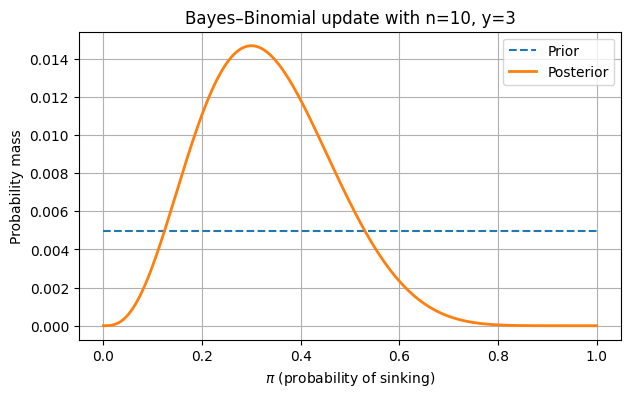

In [3]:
# First example: try changing n and y

pi_grid = make_pi_grid(num_points=201)

n = 10   # number of convoys
y = 3    # observed sinkings

prior_kind = "uniform"  # "uniform", "optimistic", "pessimistic"
prior_w = make_prior(pi_grid, kind=prior_kind)

post_w = posterior_discrete(y, n, pi_grid, prior_w)

mean_prior, prob_prior_above_half = summarize_distribution(pi_grid, prior_w, threshold=0.5)
mean_post, prob_post_above_half = summarize_distribution(pi_grid, post_w, threshold=0.5)

print(f"Prior mean pi:     {mean_prior:.3f}")
print(f"Prior P(pi >= 0.5): {prob_prior_above_half:.3f}")
print(f"Posterior mean pi: {mean_post:.3f}")
print(f"Posterior P(pi >= 0.5): {prob_post_above_half:.3f}")

plot_prior_posterior(pi_grid, prior_w, post_w, y=y, n=n)

### Guided questions (1)

Run the previous cell and then answer the following questions (in your own notes or in Moodle):

1. Compare the **prior** and **posterior** plots. In which direction did the posterior move
   (towards higher or lower values of $\pi$)? Why does that make sense given the data $(n, y)$?
2. What happens to the posterior mean when you increase $y$ keeping $n$ fixed? Try, for example,
   $y = 0, 1, 5, 8$ with $n = 10$.
3. What happens when you increase $n$ while keeping the **proportion** $y / n$ approximately constant?
   For instance, compare $(n, y) = (10, 3)$ vs. $(n, y) = (100, 30)$.

## Interactive exploration (if widgets are available)

The next cell uses **ipywidgets** to let you interactively change:

- the number of crossings $n$,
- the number of observed sinkings $y$,
- the type of prior: `uniform`, `optimistic`, or `pessimistic`.

If widgets are not available in your environment, you can still explore the model by
editing the values of `n`, `y`, and `prior_kind` in the previous code cell.

In [4]:
if WIDGETS_AVAILABLE:

            def interactive_update(n=10, y=3, prior_kind="uniform"):
                if y > n:
                    y_local = n
                else:
                    y_local = y

                pi_grid = make_pi_grid(num_points=201)
                prior_w = make_prior(pi_grid, kind=prior_kind)
                post_w = posterior_discrete(y_local, n, pi_grid, prior_w)

                mean_prior, prob_prior_above_half = summarize_distribution(pi_grid, prior_w, threshold=0.5)
                mean_post, prob_post_above_half = summarize_distribution(pi_grid, post_w, threshold=0.5)

                print(f"n = {n}, y = {y_local}, prior_kind = {prior_kind}")
                print(f"""  
Prior mean pi:          {mean_prior:.3f}
Prior P(pi >= 0.5):     {prob_prior_above_half:.3f}
Posterior mean pi:      {mean_post:.3f}
Posterior P(pi >= 0.5): {prob_post_above_half:.3f}
""")

                plot_prior_posterior(pi_grid, prior_w, post_w, y=y_local, n=n)

            interact(
                interactive_update,
                n=IntSlider(min=1, max=100, step=1, value=10, description="n"),
                y=IntSlider(min=0, max=100, step=1, value=3, description="y"),
                prior_kind=Dropdown(
                    options=["uniform", "optimistic", "pessimistic"],
                    value="uniform",
                    description="Prior"
                )
            )
else:
    print("ipywidgets not available. Please install them or use the non-interactive cells above.")

interactive(children=(IntSlider(value=10, description='n', min=1), IntSlider(value=3, description='y'), Dropdo…

### Guided questions (2)

Explore different combinations of $(n, y)$ and prior types using the interactive widget.

1. Fix $n = 20$ and try $y = 0, 1, 5, 10$. How does the posterior change? What happens to
   $P(\pi \ge 0.5)$ in each case?
2. Compare the **optimistic** and **pessimistic** priors for the same data $(n, y)$. How different
   are the corresponding posteriors? Do they still "disagree" after enough data?
3. Consider a hypothetical decision rule: *"Send heavier escort if $P(\pi \ge 0.5) > 0.7$"*.
   For which values of $(n, y)$ (and which priors) would this rule recommend heavy escort?

## Connecting with modern Data Science

The previous toy model was used to reason about U-boat attacks in a specific sea sector.
However, the same Bayesian logic appears in many modern applications, for example:

- **Spam detection**: $\pi$ could represent the probability that an email is spam.
- **Fault detection in manufacturing**: $\pi$ could represent the probability that a produced item is defective.
- **Medical diagnosis**: $\pi$ could represent the probability that a patient has a certain disease.
- **Personalised education (tutoring systems)**: $\pi$ could represent the probability that a student has mastered
  a given skill, updated as we observe their answers to exercises.

### Short reflection

Choose **one** application that is close to your personal or professional interests and answer:

1. What could the parameter $\pi$ represent in that context?
2. What are the *data* $Y$ that you would observe (analogous to the sinkings in the U-boat example)?
3. Give an example of a **prior belief** that might be reasonable before seeing any data.
4. Explain in a few lines how you would use the posterior to support a **decision**.

You can write your answers in a separate document (Moodle, learning diary, etc.) or add a new
Markdown cell below this one and type them there.

---

*Use this space (or an additional Markdown cell) to draft your reflection if you wish.*